In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import helper
import copy
from importlib import reload

Load lại data

In [9]:
X_train, X_test, y_train, y_test = helper.load_data_RNN_case2()

In [10]:
print(X_train.shape)
print(y_train.shape)

(5000, 30, 4)
(5000, 4)


# Overfitting
Sau khi thực hiện huấn luyện mô hình trên tập dữ liệu. Nhận thấy rằng đối với mô hình Feedforward Neural Network, mô hình có xu hướng rất tốt nên không cần phải thực hiện các giải pháp để giảm overfitting \
Đối với mô hình Recurrent Neural Network, mô hình có xu hướng overfitting dựa trên độ đo (metrics) độ chính xác (accuracy ~ 0.6952) và có vài chỉ số f1-score cũng rất thấp \
Chúng tôi chọn sử dụng mô hình Recurrent Neural Network với giả định trường hợp 2 để thực hiện giải pháp giảm overfitting. 

## Giải pháp 1 - Dropout và Early Stopping
Giải pháp đầu tiên là sử dụng giải pháp Dropout để giảm độ phức tạp của mô hình học máy và Early Stopping\
Giải pháp Early Stopping sẽ giúp ta giảm overfitting bằng cách dừng quá trình huấn luyện mô hình học máy khi độ chính xác trên tập dữ liệu kiểm thử không còn tăng nữa\
Để thực hiện giải pháp Early Stopping, ta sẽ sử dụng EarlyStopping callback của thư viện Keras.

In [11]:
from keras.callbacks import EarlyStopping

In [12]:
model_drop = keras.models.Sequential([
    layers.LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax'),
])

early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)
model_drop.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_drop = model_drop.fit(X_train, y_train, epochs=100, batch_size=100, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/100
40/40 [==============================] - 2s 20ms/step - loss: 1.1723 - accuracy: 0.6252 - val_loss: 1.1651 - val_accuracy: 0.5220
Epoch 2/100
40/40 [==============================] - 0s 10ms/step - loss: 0.9578 - accuracy: 0.6492 - val_loss: 1.0462 - val_accuracy: 0.5930
Epoch 3/100
40/40 [==============================] - 0s 9ms/step - loss: 0.8878 - accuracy: 0.6908 - val_loss: 0.9756 - val_accuracy: 0.6460
Epoch 4/100
40/40 [==============================] - 0s 11ms/step - loss: 0.8545 - accuracy: 0.6992 - val_loss: 0.9535 - val_accuracy: 0.6460
Epoch 5/100
40/40 [==============================] - 1s 13ms/step - loss: 0.8368 - accuracy: 0.6990 - val_loss: 0.9209 - val_accuracy: 0.6680
Epoch 6/100
40/40 [==============================] - 0s 12ms/step - loss: 0.8269 - accuracy: 0.7055 - val_loss: 0.9307 - val_accuracy: 0.6630
Epoch 7/100
40/40 [==============================] - 0s 10ms/step - loss: 0.8105 - accuracy: 0.7085 - val_loss: 0.9044 - val_accuracy: 0.6770
Epoch 8

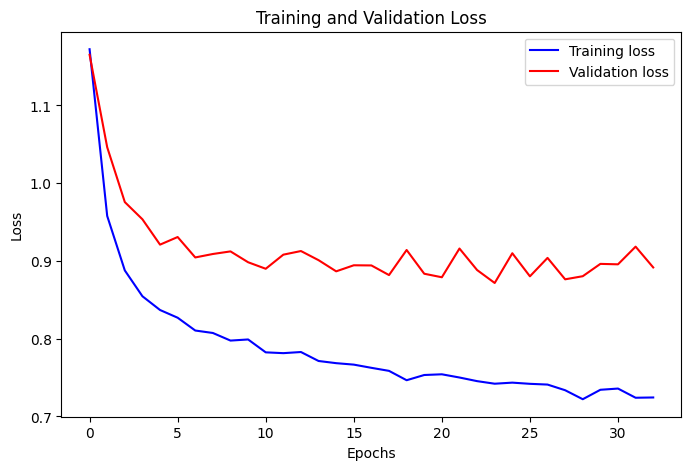

In [13]:
helper.plot_Loss_Val(history_drop)

Sau khi thực hiện giải pháp Dropout (để giảm độ phức tạp của mô hình) và Early Stopping, ta thấy rằng khoảng cách validation loss gần với training loss và có xu hướng đã giảm. \
Tuy nhiên do giá trị validation loss RNN model này ngay từ đầu có xu hướng giảm nên cũng không thể chắc chắn rằng model đã trở nên tốt hơn

### Thử dự đoán model sau khi đã thực hiện giải pháp

In [14]:
print(classification_report(y_test.argmax(axis=1), model_drop.predict(X_test).argmax(axis=1)))

29/29 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.61      0.23      0.34       151
           1       0.66      0.93      0.78       492
           2       0.00      0.00      0.00        62
           3       0.82      0.65      0.72       217

    accuracy                           0.69       922
   macro avg       0.52      0.45      0.46       922
weighted avg       0.65      0.69      0.64       922



c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### Kết luận
Sau khi dự đoán ta thấy chỉ số f1-score của class được encode 2 là 0 điều này chứng tỏ model sau khi sử dụng giải pháp 1 vẫn không có tiến triển

## Giải pháp 2 - L2 regularization

In [15]:
from keras.regularizers import l2

In [16]:
model_l2 = keras.models.Sequential([
    layers.LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)),
    layers.Dense(4, activation='softmax'),
])
model_l2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_l2 = model_l2.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=100)

Epoch 1/20
40/40 [==============================] - 2s 15ms/step - loss: 1.2546 - accuracy: 0.6250 - val_loss: 1.1917 - val_accuracy: 0.5220
Epoch 2/20
40/40 [==============================] - 0s 9ms/step - loss: 0.9719 - accuracy: 0.6490 - val_loss: 1.1109 - val_accuracy: 0.5610
Epoch 3/20
40/40 [==============================] - 0s 10ms/step - loss: 0.9175 - accuracy: 0.6770 - val_loss: 1.0325 - val_accuracy: 0.6250
Epoch 4/20
40/40 [==============================] - 0s 9ms/step - loss: 0.8593 - accuracy: 0.7042 - val_loss: 0.9643 - val_accuracy: 0.6570
Epoch 5/20
40/40 [==============================] - 0s 9ms/step - loss: 0.8333 - accuracy: 0.7117 - val_loss: 0.9677 - val_accuracy: 0.6620
Epoch 6/20
40/40 [==============================] - 0s 9ms/step - loss: 0.8132 - accuracy: 0.7168 - val_loss: 0.9768 - val_accuracy: 0.6700
Epoch 7/20
40/40 [==============================] - 0s 9ms/step - loss: 0.8048 - accuracy: 0.7188 - val_loss: 0.9541 - val_accuracy: 0.6680
Epoch 8/20
40/40 [

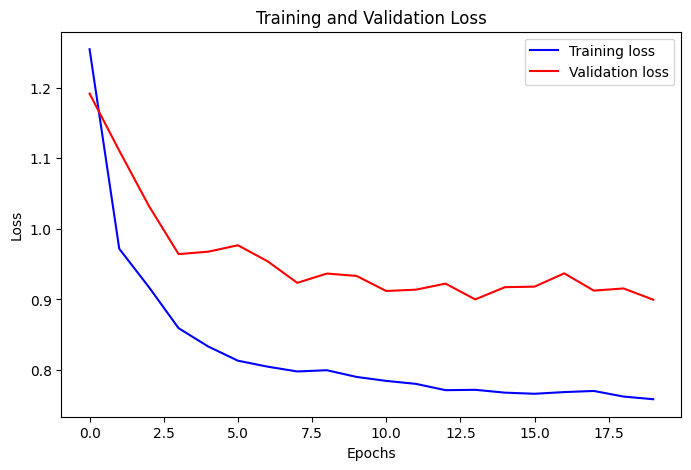

In [17]:
helper.plot_Loss_Val(history_l2)

Tương tự như giải pháp Dropout, ta thấy rằng khoảng cách validation loss gần với training loss và có xu hướng đã giảm. \
Tuy nhiên do giá trị validation loss RNN model này ngay từ đầu có xu hướng giảm nên cũng không thể chắc chắn rằng model đã trở nên tốt hơn

### Thử dự đoán sau khi sử dụng giải pháp

In [18]:
print(classification_report(y_test.argmax(axis=1), model_drop.predict(X_test).argmax(axis=1)))

29/29 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.61      0.23      0.34       151
           1       0.66      0.93      0.78       492
           2       0.00      0.00      0.00        62
           3       0.82      0.65      0.72       217

    accuracy                           0.69       922
   macro avg       0.52      0.45      0.46       922
weighted avg       0.65      0.69      0.64       922



c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### Kết luận
Tương tự như giải pháp 1, model sau khi sử dụng giải pháp này vẫn không tiến triển

# Cải thiện độ chính xác

## Giải pháp 1 - LSTM đa chiều
Giải pháp sử dụng LSTM đa chiều sẽ giúp ta cải thiện độ chính xác bằng cách sử dụng LSTM đa chiều (Bidirectional LSTM) thay vì sử dụng LSTM đơn chiều (LSTM). <br>
Qua đó, lớp LSTM đa chiều (Bidirectional LSTM) sẽ giúp ta cải thiện độ chính xác bằng cách xem xét cả thông tin từ quá khứ và tương lai. <br>
Để thực hiện giải pháp sử dụng LSTM đa chiều, ta sẽ sử dụng lớp Bidirectional của thư viện Keras. <br>

In [19]:
model_bid = keras.models.Sequential([
    layers.Input(shape=(X_train.shape[1], X_test.shape[2])),
    layers.Bidirectional(layers.LSTM(10, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(10)),
    layers.Dense(4, activation='softmax')
])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_bid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_bid.fit(X_train, y_train, epochs=50, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/50
125/125 [==============================] - 9s 26ms/step - loss: 1.0184 - accuracy: 0.6395 - val_loss: 1.1009 - val_accuracy: 0.5270
Epoch 2/50
125/125 [==============================] - 2s 14ms/step - loss: 0.8633 - accuracy: 0.6900 - val_loss: 0.9354 - val_accuracy: 0.6830
Epoch 3/50
125/125 [==============================] - 2s 13ms/step - loss: 0.7848 - accuracy: 0.7253 - val_loss: 0.8825 - val_accuracy: 0.6890
Epoch 4/50
125/125 [==============================] - 2s 14ms/step - loss: 0.7642 - accuracy: 0.7235 - val_loss: 0.8778 - val_accuracy: 0.6820
Epoch 5/50
125/125 [==============================] - 2s 16ms/step - loss: 0.7500 - accuracy: 0.7272 - val_loss: 0.8654 - val_accuracy: 0.6720
Epoch 6/50
125/125 [==============================] - 2s 17ms/step - loss: 0.7386 - accuracy: 0.7318 - val_loss: 0.8688 - val_accuracy: 0.6540
Epoch 7/50
125/125 [==============================] - 3s 21ms/step - loss: 0.7283 - accuracy: 0.7315 - val_loss: 0.8710 - val_accuracy: 0.6590

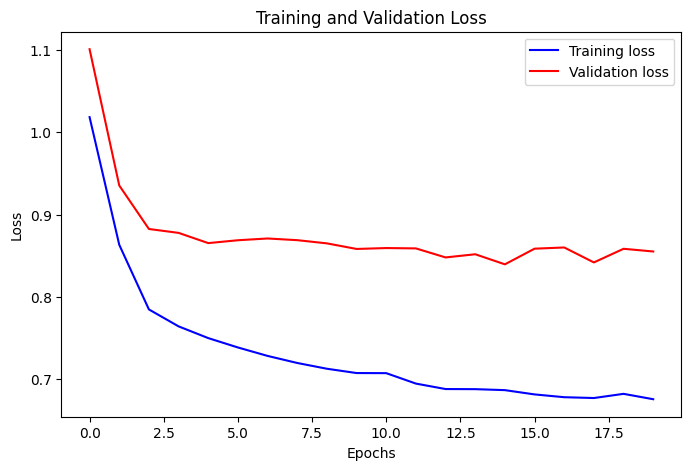

In [20]:
helper.plot_Loss_Val(history)

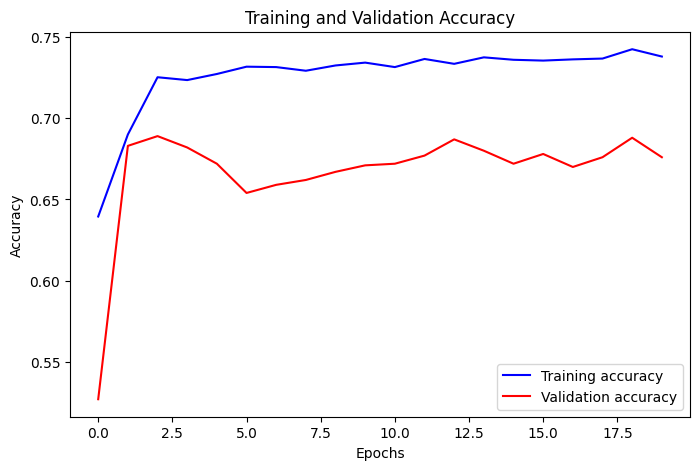

In [21]:
helper.plot_Accuracy(history)

Sau khi training ta thấy accuracy của model có sử dụng bidirection gia tăng lên mức ~ 0.72 khác model RNN - LSTM một chiều có accuracy chỉ ~ 0.67 \
Tuy accuarcy tăng không nhiều, song chỉ số accuarcy tăng không đồng nghĩa với model ta đã cải thiện.

### Thử dự đoán sau khi áp dụng giải pháp

In [22]:
print(classification_report(y_test.argmax(axis=1), model_bid.predict(X_test).argmax(axis=1)))

29/29 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.56      0.35      0.43       151
           1       0.70      0.88      0.78       492
           2       0.00      0.00      0.00        62
           3       0.82      0.77      0.80       217

    accuracy                           0.71       922
   macro avg       0.52      0.50      0.50       922
weighted avg       0.66      0.71      0.67       922



c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### Kết luận
Bidirection LSTM model tuy có accuracy được cải thiện xong vẫn không phải là model tốt do f1-score của class encode 2 chỉ là 0